# Tutorial on automatic CNN optimization for spectral analysis: regression case <font color='red'>v2</font>

**This notebook is a complementary file of D. Passos and P. Mishra, "A tutorial on automatic hyperparameter tuning of deep spectral modelling for regression and classification tasks ", Chemometrics and Intelligent Laboratory Systems, 2022 (in review). It exemplifies how to optimize the hyperparameters of a DL Convolutional Neural Network (CNN) model implemented in Tensorflow 2.5 to the dry matter content (DM %) of mango fruit based on their Vis-NIR spectra.**


The dataset used in this tutorial was first published in *N.T.Anderson, K.B.Walsh, J.R.Flynn, J.P.Walsh, Achieving robustness across season, location and cultivar for a NIRS model for intact mango fruit dry matter content. II. Local PLS and nonlinear models, Postharvest Biology and Technology, Volume 171, January 2021, 111358.*, (manuscript references [75] and [76])and was slightly modified by applying a more stringent outlier removal procedure using T and Q2 analysis (manuscript references [19]). 

The data is devided into train (2015, 2016, 2017 harvest seasons) and test (2018 harvest season).

The implementation of the Bayesian Optimization pipeline is the same used in *D. Passos, P. Mishra, An automated deep learning pipeline based on advanced optimisations for leveraging spectral classification modelling”, Chemometrics and Intelligent Laboratory Systems 215, (2021), 104354,* <url>https://doi.org/10.1016/j.chemolab.2021.104354</url>, (manuscript reference [22]) It combines TPE and Hyperband algorithms for hyperparameter optimization using the Optuna package. Learning Rate is optimized separately using a LR range test.
<br>
<br>
<font color='red'>
Version 1 of this tutorial (see original paper and notebok) was created using following main packages versions:<br>
Tensorflow  2.5.0 <br>
Tensorflow add-ons  0.13.0 <br>
tqdm  4.46.0 <br>
Numpy  1.19.5 <br>
Pandas 1.1.0 <br>
Optuna  2.9.1 
<br>    
<b>This version was modified in order to be compatible with updated versions of the packages and python 3.10.</b> <br>
Tensorflow  2.9.1 <br>
Tensorflow add-ons  0.19.0<br>
tqdm 4.64.1<br>
Numpy  1.24.<br>
Pandas 1.5.2<br>
Optuna  3.0.5<br>
Scikit-Learn  1.2.0<br>
<br>
<b>NOTE: Due to the different Tensorflow version (and the associated NVIDIA CUDADNN drivers, results may result slightly in some computations).</b>
The main differences from the original notebook are highlighted in red text in the markdown cells.
</font>    

The tutorial is divided into 7 sections:<br>
1. **Import libraries:** Import external python libraries, e.g. numpy, pandas, etc.
2. **Help functions**: functions created to aid the analysis, plots, etc. Run each cell once.
3. **Data wrangling**: load the data, perform pre-processing operations, etc...
    <br>3.1 Mango spectra dataset (with extra outliers removed on the train set)
    <br>3.2 Data pre-processing for the Convolution Neural Network (CNN) model
4. **1D CNN model**
    <br>4.1 Model definition
    <br>4.2 Apply LR Range test to the base CNN
    <br>4.3 Non-optimized model train and prediction
5. **CNN Optimization**: The optimization is done using the Optuna package
    <br>5.1 Optimization for the Learning Rate hyperparameter using a LR range test
    <br>5.2 Bayesian Optimization (BO) of the hyperparameters
6. **Analysis of the optimization analysis and final model predictions**
    <br>6.1 Making predictions with the optimized model


*<font color='red'>Notebook version: 2.0 (updated in March 2023)</font>*

## 1) Import libraries
In this first step we import all the main libraries that will be used throughout this tutorial<br>
<font color='red'>v2 - Ipython display and HTML import path updated</font>

In [21]:
## Readjust cell width in Jupyter 
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os
import sys
from sys import stdout
import logging

import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
from IPython.display import clear_output

import scipy.io as sio
from scipy.signal import savgol_filter
import tqdm

from sklearn.preprocessing import StandardScaler 
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score , KFold
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback,  ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa

## Use liveslossplot for training visualization in real time
from livelossplot import PlotLossesKerasTF

import optuna
import sklearn

<font color='red'>This version of the tutorial</font> assumes that you have installed the correct versions of the main packages used: Tensorflow, Optuna, Scikit-Learn, Pandas and Numpy:<br>
+ Tensorflow  2.9.1
+ Tensorflow add-ons  0.19.0
+ Optuna  3.0.5
+ Scikit-Learn  1.2.0
+ Pandas 1.5.2
+ Numpy  1.24.

In [2]:
## Check for version of packages
print('Tensorflow ', tf.__version__)
print('Tensorflow add-ons ', tfa.__version__)
print('Optuna ', optuna.__version__)
print('Scikit-Learn ', sklearn.__version__)
print('Pandas', pd.__version__)
print('Numpy ', np.__version__)

# print('tqdm ', tqdm.__version__)
# print('livelossplot ', livelossplot.__version__)

Tensorflow  2.9.1
Tensorflow add-ons  0.19.0
Optuna  3.0.5
Scikit-Learn  1.2.0
Pandas 1.5.2
Numpy  1.24.1


## 2) Help functions
In this section we implement a series of help functions that will be used during the optimization procedure. Run every cell once to ensure that all help functions are loaded.

Function that sets python's and TF random variable's seed to a specified value. This is important if one wants to be able to produce reproducible results. 

<div class="alert alert-block alert-warning">
    That being said, obtaining completely reproducible results when running these models on a GPU might not be possible. The Keras documentation notes that when running code on a GPU, some operations have non-deterministic outputs due to the fact that GPUs run many operations (summations) in parallel, and so the order of execution from run to run is not always the same. These operation involve floating-point with finite precision, and because of that certain GPU operations, such as convolutions, can yields slightly different results. A very small rounding error of 1e-14 in one operation can be negligible, but when this operation is done many thousands of times, this "imprecision error" at each level of the neural network (and for each batch), accumulates over layers and over time, eventually making model weights diverge significantly from run to run. If the user really needs fully deterministic computations, it might have to run the DL model on a CPU or applied specialized patches such as those proposed in the <a href="https://github.com/NVIDIA/framework-determinism">GPU-Determinism GitHub repo</a>
</div>


In [3]:
## Define random seeds ir order to maintain reproducible results through multiple testing phases
def reproducible_comp():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
reproducible_comp()

Axiliary function to compute error metrics and make prediction plots

In [4]:
## Function to compute metrics and make prediction plots
def plot_prediction(X_calib, Y_calib, X_valid, Y_valid, X_test, Y_test, Y_calib_pred, Y_valid_pred, Y_test_pred, savefig=False, figname=None):
    
    ## Compute train error scores 
    score_p0 = r2_score(Y_calib, Y_calib_pred)
    mse_p0 = mean_squared_error(Y_calib, Y_calib_pred)
    rmse_p0 = np.sqrt(mse_p0)
    
    ## Compute valid error scores
    score_p1 = r2_score(Y_valid, Y_valid_pred)
    mse_p1 = mean_squared_error(Y_valid, Y_valid_pred)
    rmse_p1 = np.sqrt(mse_p1)
        
    ## Compute test error scores 
    score_p2 = r2_score(Y_test, Y_test_pred)
    mse_p2 = mean_squared_error(Y_test, Y_test_pred)
    rmse_p2 = np.sqrt(mse_p2)

  
    print('ERROR METRICS: \t TRAIN \t\t VALID \t\t TEST')
    print('------------------------------------------------------')
    print('R2: \t\t %5.3f \t\t %5.3f \t\t %5.3f'  % (score_p0, score_p1, score_p2 ))
    print('RMSE: \t\t %5.3f \t\t %5.3f \t\t %5.3f' % (rmse_p0, rmse_p1,  rmse_p2))
    
 
    ## Plot regression for PLS predicted data
    rangey = max(Y_test) - min(Y_test)
    rangex = max(Y_test_pred) - min(Y_test_pred)

    fig=plt.figure(figsize=(6,6))
    z = np.polyfit(np.ravel(Y_test), np.ravel(Y_test_pred), 1)
    ax = plt.subplot(aspect=1)
    ax.scatter(Y_test,Y_test_pred,c='k',marker='o',s=20, alpha=0.6)
    ax.plot(Y_test, z[1]+z[0]*Y_test, c='blue', linewidth=2,label='linear fit')
    ax.plot(Y_test, Y_test, 'k--', linewidth=1.5, label='y=x')
    plt.ylabel('Predicted DM')
    plt.xlabel('Measured DM')
    plt.title('Prediction from CNN')
    plt.legend(loc=4)

    
    # Print the scores on the plot
    plt.text(min(Y_test_pred)+0.02*rangex, max(Y_test)-0.1*rangey, 'R$^{2}=$ %5.3f'  % score_p2)
    plt.text(min(Y_test_pred)+0.02*rangex, max(Y_test)-0.15*rangey, 'RMSE: %5.3f' % rmse_p2)
    if savefig==True:
        plt.savefig(figname, dpi=96)
        print('Figure saved')
    else:    
        plt.show() 
    return 

The next functions are used in the Learning Rate Finder section ahead

In [5]:
## Source / credit: 
#  https://www.kaggle.com/avanwyk/tf2-super-convergence-with-the-1cycle-policy
#  https://www.avanwyk.com/tensorflow-2-super-convergence-with-the-1cycle-policy/

## Functions to implement the LR scheduler using OneCycleScheduler

class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
    """`Callback` that schedules the learning rate on a 1cycle policy as per Leslie Smith's paper(https://arxiv.org/pdf/1803.09820.pdf).
    If the model supports a momentum parameter, it will also be adapted by the schedule.
    The implementation adopts additional improvements as per the fastai library: https://docs.fast.ai/callbacks.one_cycle.html, where
    only two phases are used and the adaptation is done using cosine annealing.
    In phase 1 the LR increases from `lr_max / div_factor` to `lr_max` and momentum decreases from `mom_max` to `mom_min`.
    In the second phase the LR decreases from `lr_max` to `lr_max / (div_factor * 1e4)` and momemtum from `mom_max` to `mom_min`.
    By default the phases are not of equal length, with the phase 1 percentage controlled by the parameter `phase_1_pct`.
    """

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')
        
class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 1000, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1, figsize=(8,6))
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses, lw=2)  

Set parameters for graphics formating

In [6]:
## Graphics settings
## Setting the font sizes for comming figures
# plt.style.use("default")
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

## uncomment for Latex graphics formating
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.sans-serif": ["Times"]})

# plt.rc('text', usetex=True)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## 3) Data wrangling

### 3.1) Mango spectra dataset (with extra outliers removed on the train set)

Read the data (matlab format) using the scipy.io module 

In [7]:
data = sio.loadmat('datasets/mango_dm_full_outlier_removed2.mat')
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'DM_cal', 'DM_test', 'Sp_cal', 'Sp_test', 'wave', 'SP_all_test', 'SP_all_train'])


'DM_cal' and 'DM_test' correspond to the dry matter content of the training and test sets. This will be the Y variable that we want to predict.'Sp_cal' and 'Sp_test' contain the original spectral data. For convenience we provide 'SP_all_test' and 'SP_all_train' that contain an augmented version of those data by concatenating spectra, SNV, 1st deriv, 2nd deriv, SNV+1st deriv and SNV+2nd deriv. 

For this specific problem of extra-seasonal DM prediction in mango, we will use data from the first three harvest seasons to calibrate/train our model and we will use the data of the fourth harvest season to test the performance of our optimized model. 

Lets take a quick look at the data: 

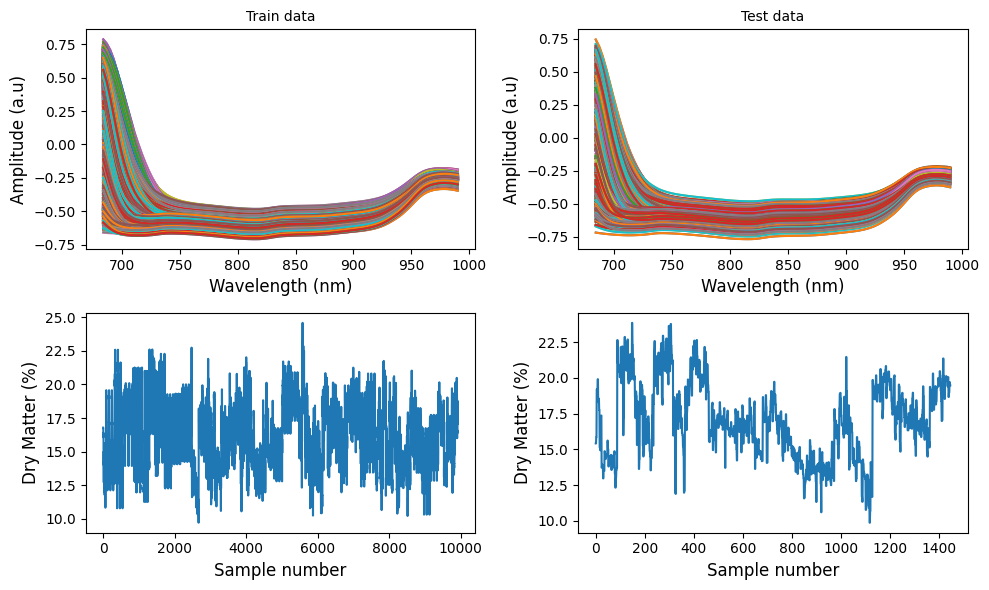

In [8]:
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.title('Train data')
plt.plot(data['wave'].T,data['Sp_cal'].T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Wavelength (nm)')
plt.subplot(222)
plt.title('Test data')
plt.plot(data['wave'].T,data['Sp_test'].T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Wavelength (nm)')
plt.subplot(223)
plt.plot(data['DM_cal'])
plt.ylabel('Dry Matter (%)')
plt.xlabel('Sample number')
plt.subplot(224)
plt.plot(data['DM_test'])
plt.ylabel('Dry Matter (%)')
plt.xlabel('Sample number')
plt.tight_layout()
plt.show()

We further split the training set into "calibration" and "tuning" subsets. This will be useful for the hyperparameter optimization of the models ahead. 

In [9]:
## Spectra (x) and target variable (Y)

## Convert data type to float32 for better inter-operability with TensorFlow
x_train=data['SP_all_train'].astype(np.float32)
y_train=data['DM_cal'].astype(np.float32)
x_test=data['SP_all_test'].astype(np.float32)
y_test=data['DM_test'].astype(np.float32)

## Spliting the full train set into calib and tuning subsets. It is important to set the 'random_state'
## parameter to a fixed value in order to guarentee that each time you run the experiment, the data is
## split the same way
x_cal, x_tuning, y_cal, y_tuning = train_test_split(x_train, y_train, test_size=0.33, shuffle=True, random_state=42) 

## The wavelenghts for the XX axis when we plot the spectra
x_scale=data['wave'].astype(np.float32).reshape(-1,1)

## Check for dimensions
print('Data set dimensions ----------------------------')
print('Full Train set dims X Y = {}\t{}'.format(x_train.shape, y_train.shape))
print('Calibration set dims X Y = {}\t{}'.format(x_cal.shape, y_cal.shape))
print('Tuning set dims X Y = {}\t{}'.format(x_tuning.shape, y_tuning.shape))
print('Test set dims X Y = {}\t{}'.format(x_test.shape, y_test.shape))
print('wavelengths number = {}'.format(np.shape(x_scale)))

Data set dimensions ----------------------------
Full Train set dims X Y = (9914, 618)	(9914, 1)
Calibration set dims X Y = (6642, 618)	(6642, 1)
Tuning set dims X Y = (3272, 618)	(3272, 1)
Test set dims X Y = (1448, 618)	(1448, 1)
wavelengths number = (103, 1)


Just a couple of plots to check data consistency!!

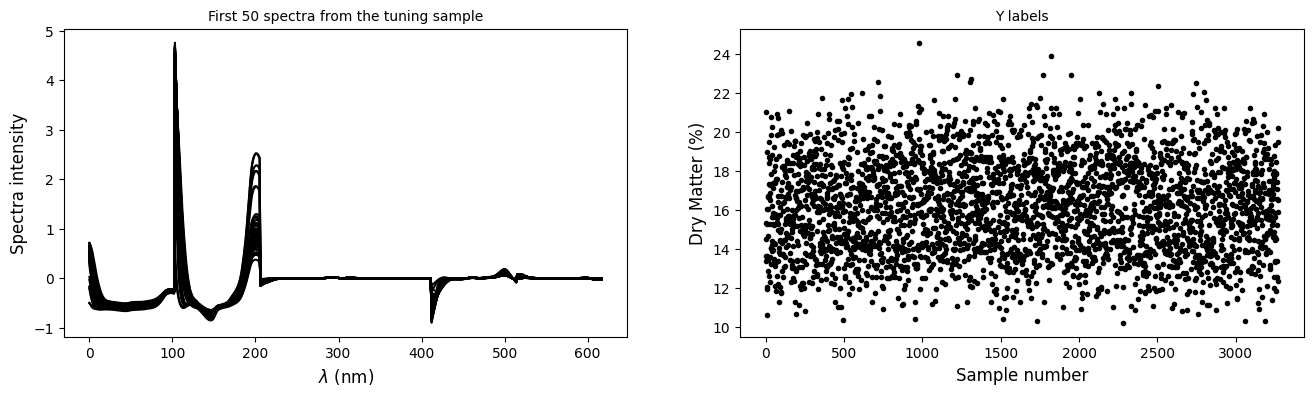

In [10]:
## Visual data sanity checking for the test set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(x_tuning[:50,:].T,'k')
plt.title('First 50 spectra from the tuning sample')
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Spectra intensity')
plt.subplot(1,2,2)
plt.title('Y labels')
plt.plot(y_tuning,'k.')
plt.xlabel('Sample number')
plt.ylabel('Dry Matter (%)')
plt.show()

The DM values in the tuning set look very scattered because the data was shuffled during the cal/tuning split. If you do the same type of plot for the test set (not shuffled), we will notice a consistent structure in the data related with the sequential measurements of the batches of mango. 

### 3.2) Data pre-processing for the Convolution Neural Network (CNN) model

Before we feed the spectral data to the CNN model, we standardize the data column-wise to put it in a range more useful to this type of algorithm.

In [11]:
## Since the test set is unknown (we are not suppose to have access to it during the
## optimization of the model) the scalling process should take this into account. We
## have to define a scaler based only on the train data, and apply it to the test data.

def standardize_column(X_train, X_calib, X_tuning, X_test):
    ## We train the scaler on the full train set and apply it to the other datasets
    scaler = StandardScaler().fit(X_train)
    ## for columns we fit the scaler to the train set and apply it to the test set
    X_calib_scaled = scaler.transform(X_calib)
    X_tuning_scaled = scaler.transform(X_tuning)
    X_test_scaled = scaler.transform(X_test)
    return [X_calib_scaled, X_tuning_scaled, X_test_scaled]

In [12]:
## Standardize on columns
x_cal_scaled_col, x_tuning_scaled_col, x_test_scaled_col = standardize_column(x_train, x_cal, x_tuning, x_test)

Just a quick look at the spectra data after standardization. We plot a few samples of the tuning set before and after the standardization.

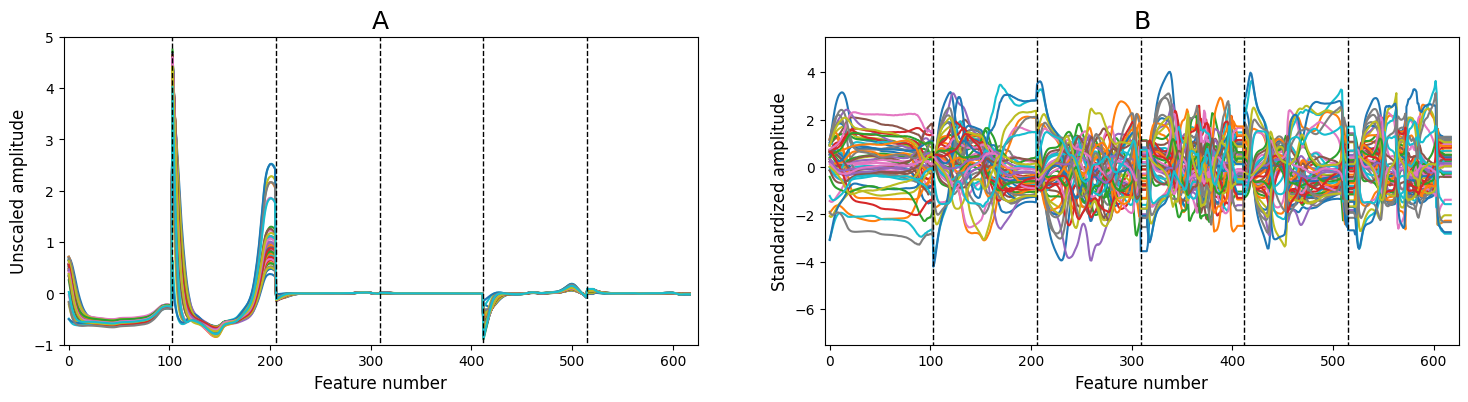

In [13]:
plt.figure(figsize=(18,4))
## left panel
plt.subplot(121)
plt.title('A', fontsize=18)
plt.plot(x_tuning[:50].T)
plt.ylabel('Unscaled amplitude')
plt.xlabel('Feature number')
## vertical dashed lines separating the types of preprocessings that were concatenated
plt.vlines(np.arange(103,600,103), ymin=-1.1, ymax=5.1, color='k',ls='--',lw=1)
plt.xlim(-5,625)
plt.ylim(-1,5)

## right panel
plt.subplot(122)
plt.title('B', fontsize=18)
plt.plot(x_tuning_scaled_col[:50].T)
plt.ylabel('Standardized amplitude')
plt.xlabel('Feature number')
plt.vlines(np.arange(103,600,103), ymin=-7.6, ymax=5.6, color='k',ls='--',lw=1)
plt.xlim(-5,625)
plt.ylim(-7.5,5.5)

plt.show()

## 4) 1D CNN model

The CNN model used here is based on the model proposed by Cui, Fearn 2018 [ref. 28 in the manuscript]. It is composed by an input layer with the same size of the input data (as usual), followed by a Conv1d layer and 4 Fully Connected layers (FC or Dense). The number of units in the first FC layer is chosen to have 1/5 of the output of the conv.layers. The number of units in the following FC layers are dropped by a factor of 2, creating a funnel effect that forces the data flow through the CNN into "higher-level / more compact representation (also called abstraction) of the input features.

The implementation of this model in tensorflow/keras is straightforward.<br> 

Some theoretical remarks before the implementation:
<br>

- **Weights initialization:**  "*The weights are initialized by a zero-mean Gaussian distribution whose standard deviation is $\sqrt{\frac{2}{n_i}}$, where $n_i$ is the number of input neurons*". This corresponds to <code>he_normal()</code> initializer in tf.keras.


- **Loss function:** The loss function proposed by *Cui, Fearn 2018* is $Loss = MSE + \frac{1}{2} \lambda \sum{w_i^2}$, i.e. the mean squared error (MSE) plus an L2 penalty $\lambda$ on the weights $w_i$. This is implemented by adding L2 regularization to the default MSE loss. Using Keras this is done by choosing the loss function as <code>'mse'</code> and apply an L2 regularization to the weights (by using <code> tf.keras.regularizers.l2(beta))</code>. The regularization hyperparameter $\lambda$ mentioned in the Cui, Fearn 2018 is related to keras $\beta$ as $\beta=\frac{\lambda}{2}$ (see [tf.keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l2)). 


- **Optimizer:** We use the 'Adam' optimizer here, due to its proven record of good performance.

### 4.1) Model definition

In [14]:
## Make sure computations are reproducible
reproducible_comp()

## This function initializes the model as a function of filter size and L2. regularization strength 
def init_model(filter_size, reg_beta):
    ## define the input layer dimensions
    INPUT_DIMS = np.shape(x_cal)[1]
    ## conv layer dimensions
    CONV1D_DIMS = INPUT_DIMS
    ## number of kernels (a.k.a. filters)
    K_NUMBER = 1
    ## kernel width
    K_WIDTH = filter_size
    ## kernel stride
    K_STRIDE = 1
    ## Number of neurons on first FC layer
    FC1_DIMS = 128
    ## Number of neurons on second FC layer
    FC2_DIMS = 64
    ## Number of neurons on third FC layer
    FC3_DIMS = 16
    ## Number of neurons on final FC layer 
    OUT_DIMS = 1 

    ## L2 regularizer parameter
    beta= reg_beta/2.

    ## For the sake of simplicity we do the weights initialization for multiple layers here
    ## Setting he_normal(seed = cte) ensures that everytime the CNN is initialized, it has the same weights configuration.
    ## This is important for reproducibility but can be detrimental for robustness.
    K_INIT = tf.keras.initializers.he_normal(seed=123)

    ## Weights L2 regularization 
    K_REG = tf.keras.regularizers.l2(beta)

    ## The CNN is implemented as a sequence of layers using keras.Sequential()
    model_cnn = keras.Sequential([  keras.layers.Reshape((INPUT_DIMS, 1),input_shape=(INPUT_DIMS,)), \
                                keras.layers.Conv1D(filters=K_NUMBER, \
                                                    kernel_size=K_WIDTH, \
                                                    strides=K_STRIDE, \
                                                    padding='same', \
                                                    kernel_initializer=K_INIT,\
                                                    kernel_regularizer=K_REG,\
                                                    activation='elu',\
                                                    input_shape=(CONV1D_DIMS,1)), \
                                keras.layers.Flatten(),
                                keras.layers.Dense(FC1_DIMS, \
                                                   kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG, \
                                                   activation='elu'),
                                keras.layers.Dense(FC2_DIMS, \
                                                   kernel_initializer=K_INIT,\
                                                   kernel_regularizer=K_REG,\
                                                   activation='elu'),
                                keras.layers.Dense(FC3_DIMS, \
                                                   kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG, \
                                                   activation='elu'),
                                keras.layers.Dense(1, kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG,\
                                                   activation='linear'),
                              ])

    return(model_cnn)

We can view all the parameters involved in this model and plot its structure to have a better intuition of it.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 618, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 618, 1)            6         
                                                                 
 flatten (Flatten)           (None, 618)               0         
                                                                 
 dense (Dense)               (None, 128)               79232     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 1)                 1

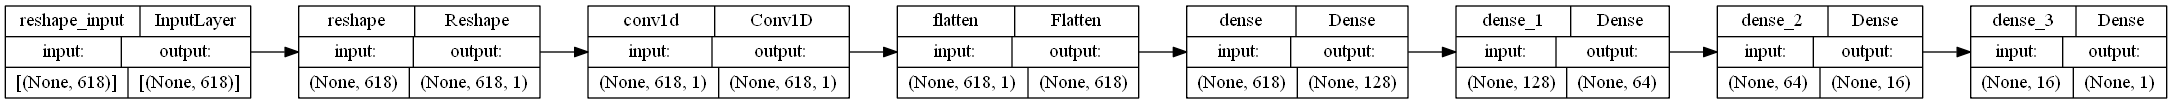

In [15]:
## Initialize a new CNN with a filter size of 5 points and L2 reg. = 0.0006 (weak regularization)
model_cnn = init_model(5, 0.0006)

## Print the summary of the model
print(model_cnn.summary())

## Plot the architecture of the CNN
## The plot_model() from Keras requires that graphviz and pydot are installed in your system.
## If you dont't have these libraries installed, skip this cell for now and browse for the image "base_cnn_regression.png" in the repository to see the result
plot_model(model_cnn,  to_file='base_cnn_regression.png', show_shapes=True, show_layer_names=True, \
           rankdir='LR', expand_nested=False, dpi=96)

### 4.2) Non-optimized model train and prediction

Here we use some default values for hyperparameters, train the CNN for 450 epochs and finally make a prediction on our test set. For the training process we will additionally use four callback functions that will help us track the training process. Callback functions are functions that tensorflow uses during training. For our training we will use:
<br> **EarlyStopping()** - Interrupts the model training once the performance stops improving 
<br> **ReduceLRonPlateau()** - Monitors the validation loss and decreases LR if validation stops improving
<br> **ModelCheckpoint()** - Saves the model parameters (weigths and biases) of the trained models into .h5 file format
<br> **PlotLossesKerasTF()** - Third party library that allows to see in real time the training progress

For a more detailed description about all these callback function, please check keras's documentation at <url>https://keras.io/api/</url>

*Practical note: if during training you get error messages associated with "permission errors", check if your files are being being used from a folder that is being sync by some third-party app like OneDrive or Dropbox.*

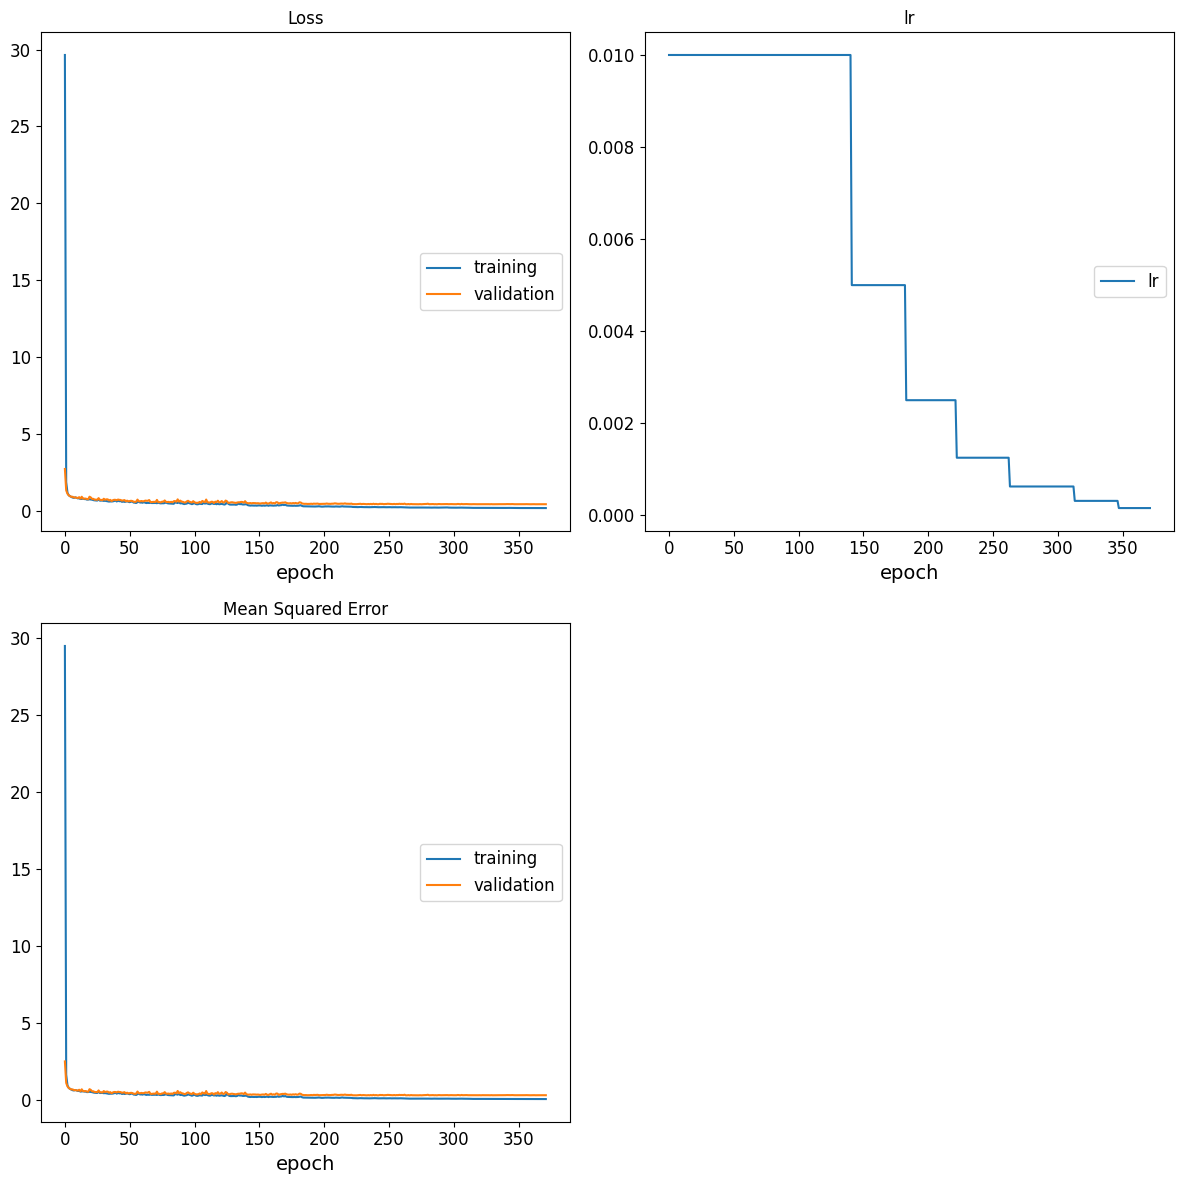

Loss
	training         	 (min:    0.163, max:   29.648, cur:    0.163)
	validation       	 (min:    0.410, max:    2.706, cur:    0.413)
lr
	lr               	 (min:    0.000, max:    0.010, cur:    0.000)
Mean Squared Error
	training         	 (min:    0.079, max:   29.488, cur:    0.079)
	validation       	 (min:    0.321, max:    2.523, cur:    0.329)
26/26 [==============================] - 1s 24ms/step - loss: 0.1631 - mse: 0.0791 - val_loss: 0.4130 - val_mse: 0.3290 - lr: 1.5625e-04


In [33]:
## Run this base model once to see if its training correctly
## This can be viewed as a baseline that hyperparameter optimization should improve

tf.keras.backend.clear_session()

########### DEFINE HYPERPARAMETERS AND INSTANTIATE THE MODEL #####################
## Define the batch size (number of sample to train for each pass into the CNN)
BATCH = 256
## Define the filter size
FILTER_SIZE = 5
## Define the L2 reg.
L2_BETA = 0.0006

## initialize the model
model_cnn=init_model(FILTER_SIZE, L2_BETA)
  
    
########### COMPILE MODEL WITH ADAM OPTIMIZER #####################################

## Heuristic that sets the learning rate 
LR=0.01*BATCH/256.
print('Adam learning rate = {}'.format(LR))

## Define the model name for saving purposes
MODEL_NAME = 'base_regression_model.h5'

## Compile the model defining the optimizer, the loss function and the metrics to track during training
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mse', metrics=['mse'])  


########### DEFINE USEFUL CALLBACK FUNCTIONS #####################################

## The following are several callbacks that can be used during training to improve its efficiency and decrease overfit
## 1) Stop the training if it does not improve
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=50, mode='auto', restore_best_weights=True)

## 2) Reduce learning rate dynamically
rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=0)

## 3) Save the best weights into file
checkpointer = ModelCheckpoint(filepath=MODEL_NAME, verbose=1, save_best_only=True)

## 4) Visualize tracked metrics in real time during training
plot_losses = PlotLossesKerasTF()

########### TRAIN THE MODEL #####################################################
## Train the model for 450 epochs on the x_cal data while monitoring the models performance on the x_tuning data.
## The data in the tuning set is not used for actual training. It is only used to measure model performance.
h1 = model_cnn.fit(x_cal_scaled_col, y_cal, batch_size=BATCH, epochs=450, \
      validation_data=(x_tuning_scaled_col, y_tuning),  \
      callbacks=[checkpointer, rdlr, early_stop, plot_losses],verbose=1)

## Clear the session. This is important to ensure that on the next training session, the weights are properly initialized.
## On the other hand if one need to continue a training session for longer, this can just be commented.
tf.keras.backend.clear_session()

The training of the CNN was saved into the history object "h1". In case of the plot_losses callback didn't work properly (or you had trouble installing it), the "plot_losses" can be removed from the list of callbacks and instead the training process can be plotted using h1.

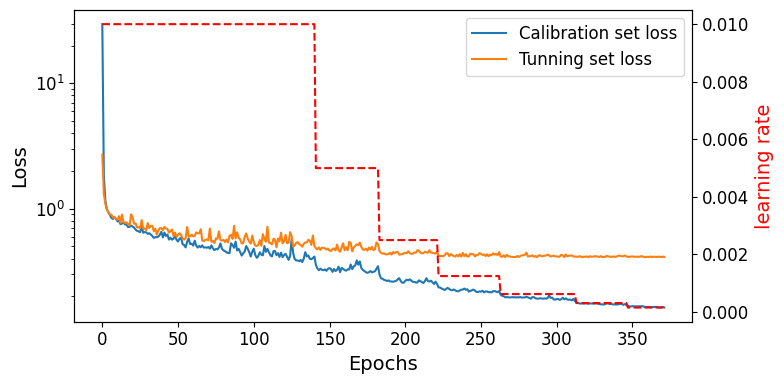

In [34]:
## If you used Livelossplot, you can skip this. Otherwise we can take a look at the training process by plotting the
## models history.
plt.figure(figsize=(8,4))
plt.plot(h1.history['loss'], label='Calibration set loss')
plt.plot(h1.history['val_loss'], label='Tunning set loss')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
# plt.ylim(0.5,1)
plt.legend()
## In case you used ReduceLROnPlateau() you can plot the lr as well
ax2 = plt.gca().twinx()
ax2.plot(h1.history['lr'], color='r', ls='--')
ax2.set_ylabel('learning rate',color='r')
plt.tight_layout()
plt.show()
# plt.savefig('train_tun_loss.png', dpi=96)

The above figure shows how the 'mse' (mean square error) is dropping during a training session, for the calibration data (blue) and for the tuning data (orange). The red stepwise line shows how the Learning Rate is being dynamically adjusted during training by the ReduceLROnPlateau() callback. In this case, the training process continued for the full 450 epochs. However, since we used the earlystop callback, it could have stopped earlier if the model improvement was below the set threshold.

<div class="alert alert-block alert-info">
<b>TIP:</b> Depending on the problem at hand, the user might not have to define a tuning set (for model validation). In the case there is just a train/calibration set, we can simply ask tensorflow to split our training data during training and use part of it for validation purposes. The alternative code would be something like:
    
<code> h = model_cnn.fit(x_train, y_train, batch_size=128, epochs=450, \
           validation_split = 0.2 , callbacks=[early_stop],verbose=1)
</code>

In this alternative example, the .fit() method would use the last 20% of the training data for validation purposes.  
</div>

Since we are now in possession of a trained CNN we can see how this model fairs in the test data. During training, the best weights configurations were being monitored by the checkpointer callback that save those weights to an .h5 file. The fist step then is to reload those best weights into our model and apply it to the test set for final predictions. We will use the plot_prediction function we defined in the beginning of the notebook.

<font color='red'>v2 - Different results obtained in the next cell evaluation. For comparison, the original work results were:<br></font>

46/46 [==============================] - 0s 1ms/step
ERROR METRICS: 	 TRAIN 		 VALID 		 TEST
------------------------------------------------------
R2: 		 0.985 		 0.944 		 0.859
RMSE: 		 0.292 		 0.570 		 1.003


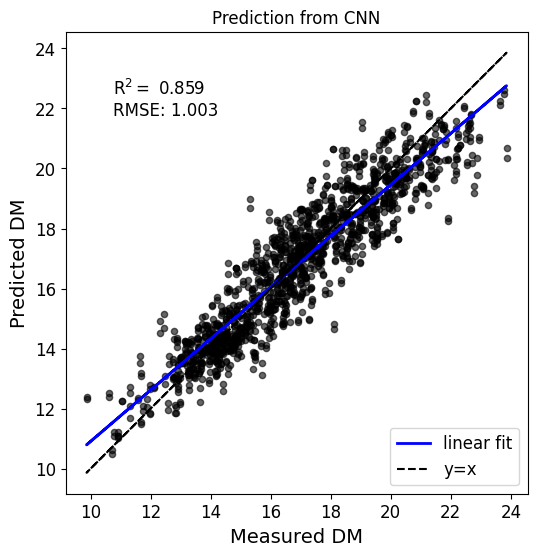

In [35]:
## Initialize a new model if needed
# model_cnn=init_model(5, 0.0003)

## load pre-computed model weights into model_cnn
model_cnn.load_weights("base_regression_model.h5")

## Compute metrics for CAL, TUNING and TEST sets
y_cal_pred1 = model_cnn.predict(x_cal_scaled_col)
y_tuning_pred1 = model_cnn.predict(x_tuning_scaled_col)
y_test_pred1  = model_cnn.predict(x_test_scaled_col)

## Plot the prediction. For this case the TRAIN column on the output corresponds to the tuning set
plot_prediction(x_cal_scaled_col, y_cal, x_tuning_scaled_col, y_tuning, x_test_scaled_col, y_test, \
                y_cal_pred1, y_tuning_pred1, y_test_pred1, savefig=False, figname='prediction_base_model.png')

## 5) CNN Optimization

Now that we know how to define a CNN model, training it and make predictions, we will proceed to see how can we optimize it in order to extract more performance from it. The following pipeline allows to optimize the convolutional filter width (<code>FILTER_SIZE</code>) and the strength of the L2 regularization(<code>L2_BETA</code>). These hyperparameters are needed to define the model itself. There are also two other hyperparameter that will be optimized, the training batch size (<code>BATCH</code>) and the Adam() learning rate (<code>LR</code>)  that is related to the training process itself. 

In case of need and depending on the computational resources available, the range of optimization could easily be extended to more hyperparameters such as the number of filters in the conv. layer, the number of conv. layers, etc... 

In [16]:
## Make computations reproducible
reproducible_comp()

## Define the model
def create_model(filter_size, reg_beta):
    ## dimensions of the input layer
    INPUT_DIMS = np.shape(x_cal)[1]
    ## dimensions of the conv. layer
    CONV1D_DIMS = INPUT_DIMS
    ## number of filters/kernels in the conv. layer
    K_NUMBER = 1
    ## filter width to be optimized
    K_WIDTH = filter_size
    ## size of the filter stride during the conv. operation 
    K_STRIDE = 1
    ## number of units in the first dense layer
    FC1_DIMS = 128
    ## number of units in the second dense layer
    FC2_DIMS = 64
    ## number of units in the third dense layer
    FC3_DIMS = 16
    ## number of units output layer
    OUT_DIMS = 1

    ## L2 regularizer parameter to be optimized
    beta= reg_beta/2.

    ## For the sake of simplicity we do the weights initialization for multiple layers here
    ## Setting he_normal(seed = cte) ensures that everytime the CNN is initialized, it has the same weights configuration.
    ## This is important for reproducibility but can be detrimental for robustness.
    K_INIT = tf.keras.initializers.he_normal(seed=123) # See what happens whem you try a different seed, e.g. 9152!

    ## Weights L2 regularization 
    K_REG = tf.keras.regularizers.l2(beta)

    ## The CNN is implemented as a sequence of layers using keras.Sequential()
    model_cnn = keras.Sequential([  keras.layers.Reshape((INPUT_DIMS, 1),input_shape=(INPUT_DIMS,), \
                                                         name='RESHAPE'), \
                                keras.layers.Conv1D(filters=K_NUMBER, \
                                                    kernel_size=K_WIDTH, \
                                                    strides=K_STRIDE, \
                                                    padding='same', \
                                                    kernel_initializer=K_INIT,\
                                                    kernel_regularizer=K_REG,\
                                                    activation='elu',\
                                                    input_shape=(CONV1D_DIMS,1),\
                                                    name='CONVOLUTIONAL'), \
                                keras.layers.Flatten(name='FLATTEN'),
                                keras.layers.Dense(FC1_DIMS, \
                                                   kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG, \
                                                   activation='elu',\
                                                   name='FC1'),\
                                keras.layers.Dense(FC2_DIMS, \
                                                   kernel_initializer=K_INIT,\
                                                   kernel_regularizer=K_REG,\
                                                   activation='elu',\
                                                   name='FC2'),\
                                keras.layers.Dense(FC3_DIMS, \
                                                   kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG, \
                                                   activation='elu',\
                                                   name='FC3'),\
                                keras.layers.Dense(1, kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG,\
                                                   activation='linear',\
                                                   name='OUTPUT'),
                              ])

    return(model_cnn)

Again, like in the introduction of the tutorial, we can initialize the CNN model and a summary of its parameters. In this specific case, the <code>num_FC_units</code> is a list of size <code>num_FC_layers</code>. The dropout entry is also a list of the same size with the dropout rate for each dropout layer. We just use this new structure and define the same number of layers, etc as previously done, just for comparison purposes.

In [17]:
model_cnn=create_model(5, 0.0006)
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RESHAPE (Reshape)           (None, 618, 1)            0         
                                                                 
 CONVOLUTIONAL (Conv1D)      (None, 618, 1)            6         
                                                                 
 FLATTEN (Flatten)           (None, 618)               0         
                                                                 
 FC1 (Dense)                 (None, 128)               79232     
                                                                 
 FC2 (Dense)                 (None, 64)                8256      
                                                                 
 FC3 (Dense)                 (None, 16)                1040      
                                                                 
 OUTPUT (Dense)              (None, 1)                

<div class="alert alert-block alert-warning">
<b>Note:</b> Each time a model is trained, even using the same hyperparameters, etc. the results might be slightly different due to the stochastic gradient descent algorithm. This is expected to happen, specially if you are running Tensorflow in a GPU. The GPU version of Tensorflow relies on the parallelization capabilities of NVidia's CUDA library that can, under certain condition, introduce some stochasticity to the process. If very high precision and reproducibility are required, the models can be trained sequentially (deterministically) on the CPU, with the trade-off of a higher computation time. For a relatively small model and input data set like the ones used in this tutorial, the GPU gains might not be to visible. For larger models (and datasets) training on a GPU offers clear advantages.
<div>    

### 5.1) Optimization for the Learning Rate hyperparameter using a LR range test

Arguably one of the most important hyperparameters in NN models is the Learning Rate (LR). This hyperparameter has a large impact in the velocity your model trains and in its stability/convergence. Usually the default LR that comes predefined in optimizer algorithm tends to work ok but its far from optimal. There are some works that highlight the interplay / interdependence between LR and Batch size which makes the heuristic used earlier  <code>(LR = 0.01*BATCH/256) </code> work well. However this rule of thumb was developed through intuition and works around 2D CNNs applied to image analysis and is not guaranteed to perform similarly well with 1d spectral data. 

The learning rate range finder test allows to have a notion of what learning rates work well for the data and CNN architecture we are using. The idea behind the LR finder is that we can train a model with a incrementally changing LR and then check for the interval (range) where stable solutions are obtained. We use the LRFinder function defined in the Help Functions section at the beginning of the notebook. 

One of the assumptions that is done here is that the LR is more dependent on the data type and LR range the obtained through this range test using the base CNN architecture is not much different from the final optimized architecture. Usually this assumption can be checked in the end of the optimization process by repeating this LRFinder test with the optimal CNN architecture.

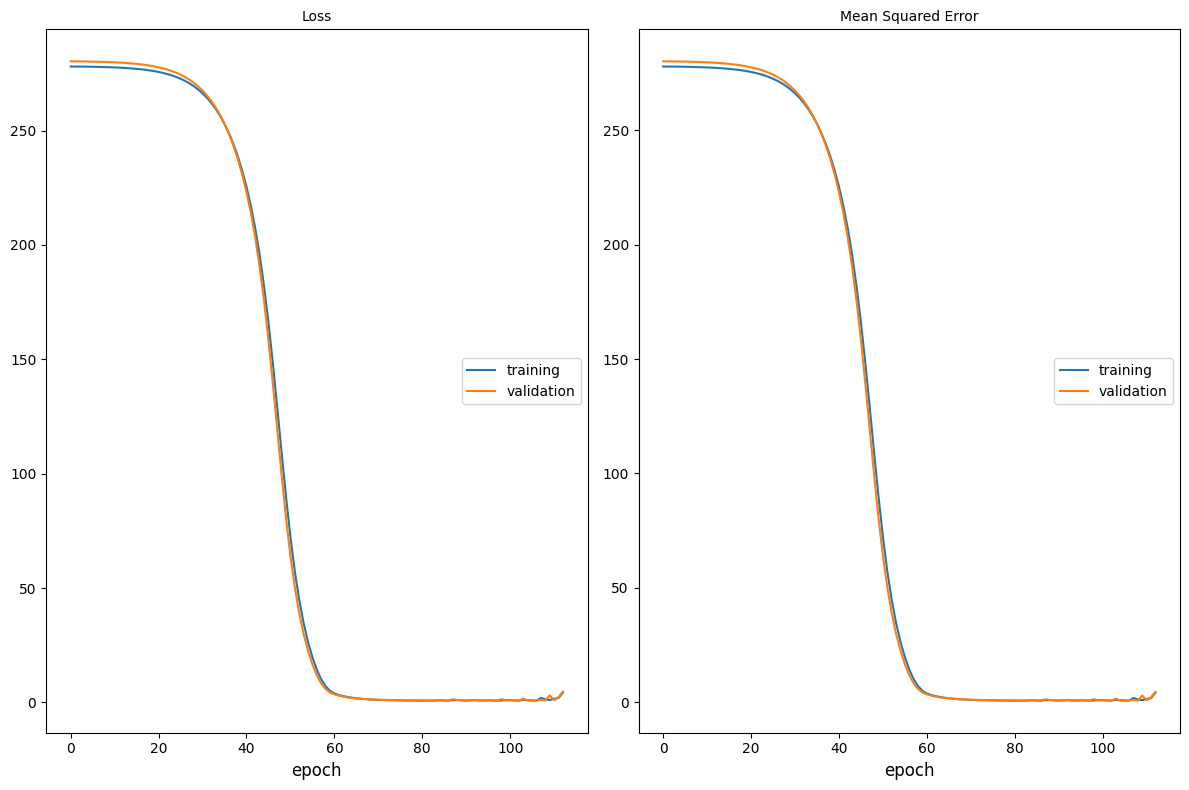

Loss
	training         	 (min:    0.765, max:  278.023, cur:    4.265)
	validation       	 (min:    0.716, max:  280.291, cur:    4.721)
Mean Squared Error
	training         	 (min:    0.633, max:  277.898, cur:    4.067)
	validation       	 (min:    0.587, max:  280.165, cur:    4.512)
26/26 [==============================] - 0s 14ms/step - loss: 4.2650 - mse: 4.0673 - val_loss: 4.7210 - val_mse: 4.5121


In [18]:
## Max training epochs
EPOCHS = 450
## Batch size
BATCH = 256

## number of steps 
step_base=0.25*np.ceil(len(x_cal_scaled_col) / BATCH) * EPOCHS
print('Optimizing LR for {} steps'.format(step_base))

## Start with a small LR = 1e-8 to ensure convergence and progressively increase LR until end_lr. 
## The smoothing factor help smooth out the mse during training. You can experiment with these values to see what happens to the loss curve... 
lr_finder_base = LRFinder(start_lr= 1e-8, end_lr = 0.5, max_steps= step_base, smoothing=0.9)

# MODEL_NAME='base_model.h5'

## clear the session
tf.keras.backend.clear_session()

## initialize the model
model = create_model(5, 0.0006)
## compitle the model
model.compile(optimizer=keras.optimizers.Adam(),loss='mse',metrics=['mse']) 

## Callback to visualize the training
plot_losses = PlotLossesKerasTF()

## Train the model using lr_finder_base as LR scheduler in the callback list
h3 = model.fit(x_cal_scaled_col, y_cal, batch_size = BATCH, epochs = EPOCHS, \
              validation_data=(x_tuning_scaled_col, y_tuning),  \
              callbacks=[lr_finder_base, PlotLossesKerasTF()],verbose=1)  


From the previous figures we can see that in the beginning of the training process, when the LR is very small, the model doesn't actually learn anything. This correspond to the mse plateau between epochs 0 and 35. Only between epochs ~40 and 60 there is a visible improvement of the mse (the model is learning something). After epoch ~65 the performance plateaus again. This is more clear by plotting 'mse-loss' vs LR instead of 'mse loss' vs epoch. We can apply the method .plot() previously defined in LRFinder() to see this.

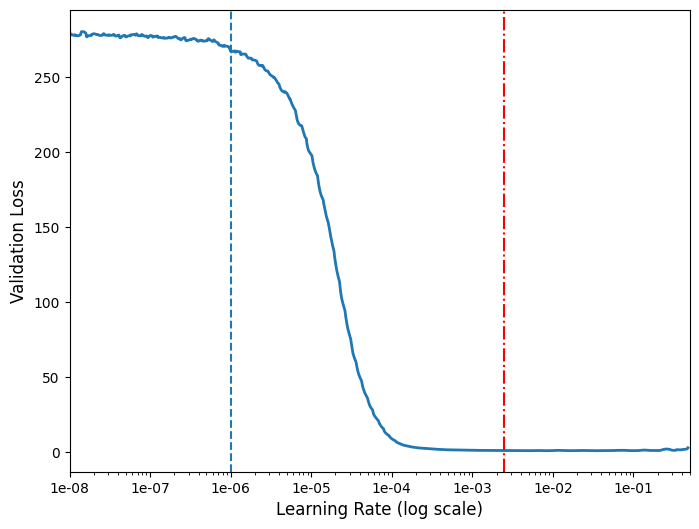

In [19]:
lr_finder_base.plot()
plt.axvline(1e-6, ls='dashed')
plt.axvline(0.0025, ls='dashdot', color='r')
plt.ylabel('Validation Loss')
plt.xlim(1e-8, 0.5)
plt.show()

The blue dashed line marks the LR at which our model starts to learn something. For lower LR, this test indicates that the model doesn't improve. With this in mind the LR = 1e-5 is chosen as a lower limit for LR. On the other hand, the red dashed line, sits in the middle of the region where larger LR also don't contribute to the improvement of the model (i.e. the loss is basically constant). A LR = 0.0025 is chosen as the max LR allowed. A larger LR could lead to faster training processes but at the risk of the model to become unstable and never actually converge to a minimum or even leading to "gradient explosions". You can try and set the end_lr in the previous cell to a higher value (e.g. 0.9) and you will see that most likely the training process will blow up (sharp upward peak at the end of training).

For example we could choose one of the values in this range (preferably around 1e-4) as a fixed LR during the whole training. However, our current model implementation takes advantage of the ReduceLRonPlateau() callback that allow to dynamically decrease LR to improve the optimizer's convergence. Therefore, we set the min LR that ReduceLRonPlateau() allows as the lower LR found with the LRFinder test and the initial Adam LR as the max LR found with the LRFinder test. This allows for an initial fast convergence of the model (large LR) and when needed it can be decreased by ReduceLRonPlateau() to improve convergence on a minima. 

### 5.2) Bayesian Optimization (BO) of the hyperparameters

We have finally arrived to the section of the notebook where we use a Bayesian Optimization method to find the optimal hyperparameters for our model. More than finding the optimal hyperparameters, this pipeline also allows for a restricted Neural Architecture Search (NAS). Remember that we are also testing for slightly different neural architectures by probing different number of FC layers and dropout layers. These are not hyperparameters *per se*, but instead are characteristics of the neural network architecture itself. In the example we present here we restrict the NAS to a small number of FC (2 to 5) and dropout layers. However, depending on the available computational resources, the reader could expand this NAS to a higher search space with different types of layers (eg. multiple conv. layers, bach normalization layers, etc.) in order to be able to explore much more complex architectures. 

<div class="alert alert-block alert-warning">
From experience we can say that there are some considerations to take care when performing this type of automated approach. If one allows a very shallow architecture (e.g. just 1 FC layer) with a large number of units (e.g. very wide), there is a tendency for this automated NAS method to procure this type of solutions instead of deeper architectures. This goes in hand with the empirical evidence that shallow but wide neural networks are more prone to "memorize" the dataset and have less generalization capacities than deeper networks. One should be aware of these caveats/limitations when setting up the NAS space. 
</div>    

The method of BO that we apply is called Tree Parzen Estimator (TPE) associated with a pruning method (Hyperband). While TPE looks for the best values of hyperparameters according to distribution functions and Bayes rules, the Hyperband algorithm improves the pipeline speed by discarding less promising trials (made by using less favorable combinations of the hyperparameter space). The hyperband algorithm trains models defined using multiple combinations of hyperparameters for a few epochs, discards the less promising, and resumes training on the most promising ones.

There are a few python (and Matlab) libraries that simplify this kind of BO task, but we choose the Optuna library due to its versatility, documentation and "easiness" of use. 

In [20]:
## We start by calling a callback that allows for hyperband to "talk" to keras and terminate/resume training
from optuna.integration import TFKerasPruningCallback

## Set the path where the computed models are saved
## Beware of path notation differences between windows (\\) and linux (/) systems
path='regression_models\\'

## initialize an empty list for storing additional metrics
metricas=[]

## Callbacks to use during training
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=50, mode='auto', restore_best_weights=True)  
## Note that the min_lr in rdlr is the one found in the LRFinder test

rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)

## This callback draws small progress bar in the screen for each training session. Its useful to check the progress of the task
progressbar=tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

## Subclass ModelCheckpoint -  Custom ModelCheckpoint to save models only after a certain number of epochs (to save resources)
## This is a custom version of the ModelCheckpoint() callback that only saves the best models if they are trained for more than 150 epochs
## By using this, the less promising models that hyperband will discard, are not saved to disk. This leads to less saved models in the disk.
class CustomModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super(CustomModelCheckpoint, self).__init__(*args, **kwargs)

    ## redefine the save so it only activates after 150 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch > 150: super(CustomModelCheckpoint, self).on_epoch_end(epoch, logs)


## Define the objective function to monitor during optimization, set the hyperperameters ranges, etc.
## In this section we define the most important part of the optimization process, i.e, the objective function or value that our 
## BO will try to minimise. In this function we define all the hyperparamters intervals or search space that will be used in 
## the optimization. 
def objective(trial):
    
    ## Clear clutter from previous session   
    keras.backend.clear_session()
    
    ## define the model/study name. In this case we will save a model with the same name of its trial
    ## Remember, one trial is training a model with a specific set of hyperparameters
    MODEL_NAME='study_trial='+str(trial.number)+'.h5' 
    
    ## In the follow steps we define the search space for each of the hyperparameters. This is done by using
    ## distributions/intervals of integers or floats from a min, to a max with a certain step.
        
    ## filter size  (K_WIDTH)
    FILTER_SIZE = int(trial.suggest_int("filter_size", 5, 51, step = 2)) 
    
    ## L2 regularization
    REG_BETA = trial.suggest_float("reg_beta", 0., 0.05, step=0.0005)
    
    ## Instantiate the model with values samples from the previous defined intervals
    model = create_model(FILTER_SIZE, REG_BETA)
    
    ## Add batch size to the hyperparameters to be optimized. This hyperparameter is not used directly by the model
    ## but is used in the training phase.
    
    BATCH_SIZE = int(trial.suggest_int("batch_size", 64, 256, step = 64))
    ## Add batch size to the hyperparameters that Optuna logs
    trial.set_user_attr("batch_size", BATCH_SIZE)
    
    ## Initial LR for Adam optimizer corresponding to the LRmax chosen in the LRFinder test
    LR=0.0025  
    
    ## Alternatively we could set the initial LR using the previously mentioned heuristic as a function of BATCH_SIZE
    # 0.01*BATCH_SIZE/256.
    
    ## Compile the model, use Adam() as optimizer, and mean squared error (mse) as loss function
    ## Note: the learning_rate in Adam() is set to the max LR found in the LRFinder test
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
          loss="mse",
          metrics=["mse"])
        
    ## Callbacks
    custom_checkpointer= CustomModelCheckpoint(filepath=path+MODEL_NAME, verbose=0, save_best_only=True)  
    ## Alternatively we could save all models using the default ModelCheckpoint()  
    # checkpointer= keras.callbacks.ModelCheckpoint(filepath=path+MODEL_NAME, verbose=1, save_best_only=True)
    
    
    ## Train the model on train data and validate it on tuning (val) data
    ## Note: The callback TFKerasPruningCallback(trial, 'val_loss') is necessary to convey val_loss info to the Hyperband pruner
    history = model.fit(x_cal_scaled_col, y_cal, batch_size = BATCH_SIZE, epochs = 450, \
                        validation_data = (x_tuning_scaled_col, y_tuning), \
                        callbacks=[rdlr, early_stop, custom_checkpointer, TFKerasPruningCallback(trial, 'val_loss'), progressbar], \
                        verbose=0)
    
    ## Compute auxiliary metrics
    scores_cal = model.evaluate(x_cal_scaled_col, y_cal, verbose=0)
    print('Calibration rmse={}'.format(np.sqrt(scores_cal[1])))
       
    scores_tuning = model.evaluate(x_tuning_scaled_col, y_tuning, verbose=0) 
    print('Tuning rmse={}'.format(np.sqrt(scores_tuning[1])))
    
    ## Append each trial's hyperparameters and scores into a list for later analysis 
    metricas.append([MODEL_NAME, FILTER_SIZE, REG_BETA, BATCH_SIZE, \
                     np.sqrt(scores_cal[1]), np.sqrt(scores_tuning[1]) ])
    
    ## The metric we want to minimize. In this case we are chosing weighted sum between tuning and cal metrics
    return 0.5*np.sqrt(scores_tuning[1]) + 0.5*(np.abs(scores_tuning[1] - scores_cal[1]))

In the <code>objective(trial)</code> function we defined our model, the hyperparameters ranges that will be explored by the BO and the objective function we want to minimize. A usual choice for this type of problem would be the MSE or the root mean squared error ($RMSE$) on the tuning set. However, given the previous observation that the model might be overfitting the calibration data, we choose a more complex objective function as a weighted sum of tuning and overfit errors
<p>
    <center>
        $Objective = w_1 \times RMSE_{tuning} + w_2 \times |MSE_{tuning} - MSE_{cal}|$, 
    </center>
<p>

that enforces the model to generalize better (looking for low tuning RMSE) and avoid overfit (by minimizing the absolute difference between tuning and calibration MSEs). In case of need, for some specific cases, Optuna also allows for the definition of multiple objective functions.

In the next cell we define a study object that takes into account the objective function, the type of optimization (minimization in this case), the algorithm of choice (TPE), the number of trials (500), the pruner algorithm (hyperband), etc. In the end of the cell we instantiate the optimization of this study, and the optimization process starts. Depending on the computational resources, model type, data size, number of trials, etc. this process can take from hours to days. In what follows, for the purpose of this tutorial we optimize the model for 500 trials with the prior knowledge that this might be a small number of trials for the hyperparameter space we have defined. 

One of the things to have in mind is that the optuna.TPEsampler algorithm has a "warm-up phase", i.e. it starts by randomly probing the hyperparameters space for the first <code>n_startup_trials</code> (effectively equivalent to a random grid search) to ensure exploration and only after that number of trials, it starts to use the TPE algorithm to exploit the most promising directions. That being said, beyond this tutorial, it is recommended that we start with a large enough <code>n_startup_trials</code> (to ensure good exploration) and use a much larger number of trials to improve exploitation.

In a modest workstation (e.g. Intel Core i7 4790k, 16Gb RAM and a NVidia RTX 2080 Ti) these 500 trials should take about 14h 5min.
For convenience, we also share the a precomputed <code>study</code> object (file study_precomputed.db) that contains the results from our optimization round and some pre-trained models in the folder $\texttt{regression_models/pre-trained/}$. At this point you can 1) run the next code cell as it is and wait for the full 500 trials, 2) you can modify the trial number to something smaller (e.g 20) and just check if everything is running ok or 3) if you want to skip ahead and go directly for the results analysis, don't run the next cells and jump to **Section 6)**.

<div class="alert alert-block alert-warning">
In this next cell we create the <code>study_v2</code> object. If a study with the same name has already been created, Optuna will add the new trials to that object, i.e., the optimization process will be resumed from a previous optimization session. For this reason, in this tutorial, the final results from our (the authors) initial optimization has been renamed as "study_precomputed.db" in the attached files. 
<div>  

<font color='red'>v2 - For this updated version of the notebook, the following cell computations were interrupted around 50 iterations. This is enough for the purpose of this demonstration. The new study object is now called study_v2.<br></font>

In [ ]:
## Enable Optuna logger (for tracking purposes) 
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

## Unique identifier of the study
study_name = "study_v2"  

## Name of the SQL data base where optuna saves the trials, values, etc... 
## The optimization and logs the results into a database .db file that can be monitored in real time with the optuna-dashboard
storage_name = "sqlite:///{}.db".format(study_name)

## Create a study that will, in this case minimize the objective function previously defined
## We use TPE with a cte seed (for reproducibility) and n_startup_trials = 66 (random search picks) to 
## warm up the BO. In this study we also enable multivariate = True in order for the TPE alg. to look for
## relatioships between hyperparameters (it creates multivariate kernel densities instead of single kernel
## densities). The multivariate option is still experimental in optuna 2.8 but our in-house test seem to favor it.
## Pruning is done with the HyperBand algorithm and we allocate a min_resource of 50 epochs
## per model to guarantee that the convergence level is high enough to ensure reliable solutions before the
## hyperband to act as pruner.
study = optuna.create_study(study_name=study_name, \
                            storage=storage_name,  \
                            direction='minimize',  \
                            sampler = optuna.samplers.TPESampler(seed = 123, 
                                                                 consider_endpoints = True, 
                                                                 multivariate = True,
                                                                 n_startup_trials = 50),\
                             pruner=optuna.pruners.HyperbandPruner(min_resource=50, reduction_factor=4),\
                             load_if_exists=True)

## In the case that we have already found (by trial and error) some nice hyperparameters, we can 
## enqueue them into the hyperparameter search space. This way the pruner will be more effective
## because the search will start from an already good solution (relatively low rmse in this case).
## For example we might want to enque the hyperparameter values that we used for our base cnn.
study.enqueue_trial({ "filter_size":5,
                      "reg_beta":0.003,
                      "batch_size":256,
                       })

## Start optimization with a budget of 500 trials. Notice: for faster results you might use the flag n_jobs=-1 inside the 
## following function to enable multithread parallelism and increased speed. Only the CPU dependent sections will be parallelized.
study.optimize(objective, n_trials = 500)

## The output of this cell is omitted here for improved readability of this notebook online. The output can be
## checked in the regression_log.txt file saved in the parent folder.

<div class="alert alert-block alert-warning">
The output of the previous cell was removed to improve the online readability of the notebook. Ignore this warning if you are running this yourself.
    
The remainder of **Section 5)** assumes that the user ran the optimization cell and generated his own <code>study_v2</code>.    
<div>    

All our basic metrics and parameters for all trials have been stored in the list <code>metricas</code>. We can convert this list to a Pandas DataFrame for easier handling and query. This DataFrame can also be saved into a .csv file for posterior reload and analysis. <br>

<font color='red'>If you skipped the optimization step and want to continue and learn how to look at the output results, you can load the version that we provide using <br>
<code> metricas_df=pd.read_csv("metricas_pre_computed.csv", index_col=0) </code> <br>
    for the original optimization run or <br>
<code>metricas_df=pd.read_csv("metricas_pre_computed_v2.csv", index_col=0) </code><br>
for smaller optimization run made in this update v2 version, and skip the next 3 cells.

In [44]:
metricas_df=pd.DataFrame(metricas, columns=['MODEL_NAME', 'FILTER_SIZE', 'REG_BETA', 'BATCH_SIZE', 'RMSE_CAL', 'RMSE_TUNING' ])
## Note: metricas contains all the trials values that were not pruned by hyperband.

<font color='red'>v2 - Importing the smaller optimization results made in this .v2 update for demonstration purposes. Remember, since we set the seed=123 in the optuna.samplers.TPESampler(seed = 123...) function, your own run results should not differ too much from the present results. Off course there is always gradient descent related variations in the training of the CNNs but that is another issue that can be resolved by enabeling new determininm flags in Tensorflow, see: https://www.tensorflow.org/api_docs/python/tf/config/experimental/enable_op_determinism <br></font>

In [50]:
## Save "metricas" list as .csv file 
metricas_df.to_csv('metricas_v2.csv')

[I 2023-03-17 10:34:24,139] Trial 101 pruned. Trial was pruned at epoch 200.


Trial 101 pruned. Trial was pruned at epoch 200.
Trial 101 pruned. Trial was pruned at epoch 200.


In [51]:
## print metricas
metricas_df.head()

,MODEL_NAME,FILTER_SIZE,REG_BETA,BATCH_SIZE,RMSE_CAL,RMSE_TUNING,RMSE_OBJFUNC
0,study_trial=0.h5,5,0.003,256,0.382972,0.585881,0.391235
1,study_trial=1.h5,37,0.014,64,0.519928,0.600945,0.345878
2,study_trial=2.h5,31,0.036,128,0.613465,0.667756,0.368658
3,study_trial=4.h5,23,0.017,192,0.496350,0.600641,0.357523
4,study_trial=5.h5,25,0.003,128,0.301934,0.553038,0.383862


Since we didn't saved the objective function value into the <code>metricas</code> list, in order to find the best model from the optimization we have to check where $Objective = w_1 RMSE_{tuning} + w_2 |MSE_{tuning} - MSE_{cal}|$, has the lowest value:

In [52]:
## Get RMSE metrics
rmse_tun = metricas_df.RMSE_TUNING
rmse_cal = metricas_df.RMSE_CAL
## Recompute MSE 
mse_tun = rmse_tun*rmse_tun
mse_cal = rmse_cal*rmse_cal 

## Add a new column to the metricas_df dataframe with the result of the objective function
metricas_df['RMSE_OBJFUNC'] = 0.5*rmse_tun + 0.5*(np.abs(mse_tun - mse_cal))

## show the first records of "metricas" sorted by values by 'RMSE_OBJFUNC'
metricas_df.sort_values(by='RMSE_OBJFUNC').head()

,MODEL_NAME,FILTER_SIZE,REG_BETA,BATCH_SIZE,RMSE_CAL,RMSE_TUNING,RMSE_OBJFUNC
1,study_trial=1.h5,37,0.0140,64,0.519928,0.600945,0.345878
3,study_trial=4.h5,23,0.0170,192,0.496350,0.600641,0.357523
5,study_trial=10.h5,15,0.0145,192,0.554023,0.628503,0.358288
8,study_trial=28.h5,37,0.0275,128,0.592519,0.649253,0.359852
6,study_trial=22.h5,37,0.0425,64,0.618410,0.663024,0.360098


<font color='red'> .v2 - As we can see, in this case **trial 1** provided the lowest value for the target objective function that the optimization loop used. Different optimization rounds will get different results.

Alternatively (and much more easy) Optuna allows to directly query the <code>study</code> object to find what was be best hyperparameters. If you skipped the optimization step and the object <code>study</code> was not created, you can skip to **Section 6)**.

In [53]:
study.best_trial.number

1

In [54]:
study.best_trial.params

{'batch_size': 64, 'filter_size': 37, 'reg_beta': 0.014}

In [55]:
study.trials[1].params

{'batch_size': 64, 'filter_size': 37, 'reg_beta': 0.014}

## 6) Analysis of the optimization analysis and final model predictions

If the optimization was generated in a previous session or in another machine, one can load the <code>study_v2</code> (any pre-computed <study>study</study>) and analyze it directly by exploring the information logged by this Optuna object. In this section we exemplify this by using the precomputed <code>study</code> object and corresponding pre-trained models that we provide. If the user ran all the cells for the optimization, a new study has been generated and the following cells should be modified accordingly to use that file.

<font color='red'> The current version of optuna uses a different storage format for the database objects .db. The previous format can be converted to the current standard. We did this for the .db file generated in the original notebook by using the command: <code> optuna storage upgrade --storage sqlite:///study_precomputed.db </code> and by renaming this file to study_precomputed_v2.db. In this notebook you can either import study_v2.db, the previous version that is study_precomputed.db or other XXX.db file that you have generated.</font>

In [67]:
## CHOOSE ONE OF THE FOLLOWING BY COMMENTING THE OTHER OPTIONS

## Load previously computed study done with optuna 2.9 and translated into the new storage format of optuna 3.0
loaded_study = optuna.load_study(study_name="study", storage="sqlite:///study_precomputed_v2.db")

## Smaller study done in this .v2 version of the notebook
# loaded_study = optuna.load_study(study_name="study_v2", storage="sqlite:///study_v2.db")

## To check the results from the optimization you generated, just run the same command for your study object
## loaded_study = optuna.load_study(study_name="study", storage="sqlite:///study.db")

Loaded study can now be probed and the relevant variables listed:

In [68]:
print('Best trial:',loaded_study.best_trial.number)
print('Best trial value:',loaded_study.best_trial.value)
print('Best trial hyperparameters:',loaded_study.best_trial.params)

Best trial: 156
Best trial value: 0.3480654454179174
Best trial hyperparameters: {'batch_size': 128, 'filter_size': 45, 'reg_beta': 0.015}


Optuna provides a several visualization options that can help access the quality of the optimization process. Here is one example of the optimization history. Additional examples are presented in the companion classification tutorial and in the Optuna documentation online.

C:\Users\dmcp\AppData\Local\Temp\ipykernel_19880\3126476653.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(loaded_study)


(-20.0, 500.0)

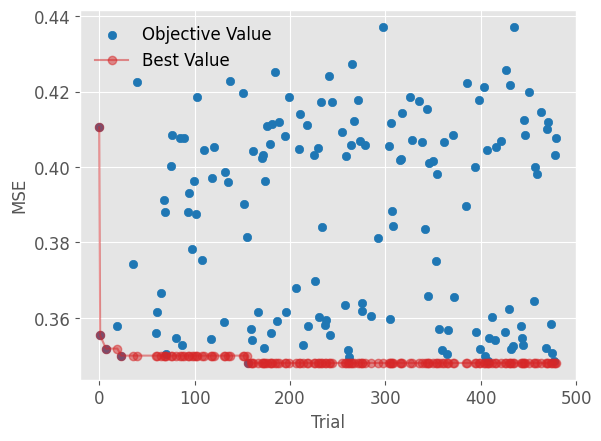

In [69]:
optuna.visualization.matplotlib.plot_optimization_history(loaded_study)
plt.title('')
plt.ylabel('MSE')
plt.legend(frameon=False)
plt.xlim(-20,500)

### 6.1 Making predictions with the optimized model

After finding what was the best trial for our

46/46 [==============================] - 0s 1ms/step
ERROR METRICS: 	 TRAIN 		 VALID 		 TEST
------------------------------------------------------
R2: 		 0.955 		 0.940 		 0.898
RMSE: 		 0.501 		 0.588 		 0.853


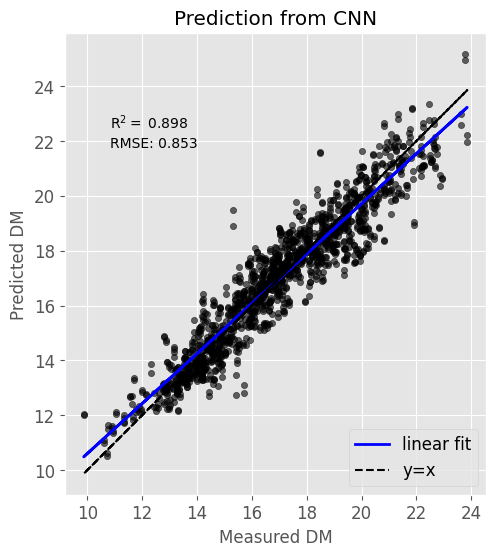

In [70]:
## Initialize a model with the best found hyperparameters
model_cnn = create_model(45, 0.015)

## Load the weights of the pre-trained / saved corresponding model
## load pre-computed model weights into model_cnn
model_cnn.load_weights("regression_models/pre-trained/study_trial=156.h5")

## Compute metrics for CAL, TUNING and TEST sets
y_cal_pred3 = model_cnn.predict(x_cal_scaled_col)
y_tuning_pred3 = model_cnn.predict(x_tuning_scaled_col)
y_test_pred3  = model_cnn.predict(x_test_scaled_col)


## Plot the prediction metrics using the custom function "plot_prediction", defined in the initial Help section.
plot_prediction(x_cal_scaled_col, y_cal, x_tuning_scaled_col, y_tuning, x_test_scaled_col, y_test, y_cal_pred3, y_tuning_pred3, y_test_pred3, savefig=False, figname='prediction_base_model1.png')

One common methodology usually applied in ML problems is to aggregate back the calibration and tuning data sets into a unique train set and retrain the optimized model on all available training data. In this case, we can use the initial train set that we loaded in the beginning of this notebook (after standardize it like we did to the other data set).

<div class="alert alert-block alert-warning">
<b>Note</b>: Please note that this time there is no tuning/validation set, so, we have to modify the callbacks EarlyStopping() and ReduceLROnPlateau() to monitor the model  loss <code>('loss')</code> and not the model's validation loss <code>('val_loss')</code>. The same applies to ModelCheckpoint(). Our initial modeling strategy is based on the assumption that the model generalizes better if it is forced to adapt the LR as a function of performance on the validation data (validation loss). By not using a validation set, we cannot be sure that the LR that will be defined iteratively by ReduceLROnPlateau() will contribute to better model generalization as before! This strategy of retraining the model on the full training set tend to present better results when the LR is kept fixed during the train. For these cases, LR can also be one of the hyperparameters that are optimized by the Bayesian optimization loop.
One other thing that we can do is to load the weights of the best model found so far and use those weights to initialize the training on the full train set for a some additional 600 epochs. This way we start the CNN optimization near a minimum basin in the error loss landscape. In order to keep this learning stable, it is advised to lower the LR as well to avoid gradient descent to jump out the minimum basin.
</div>   


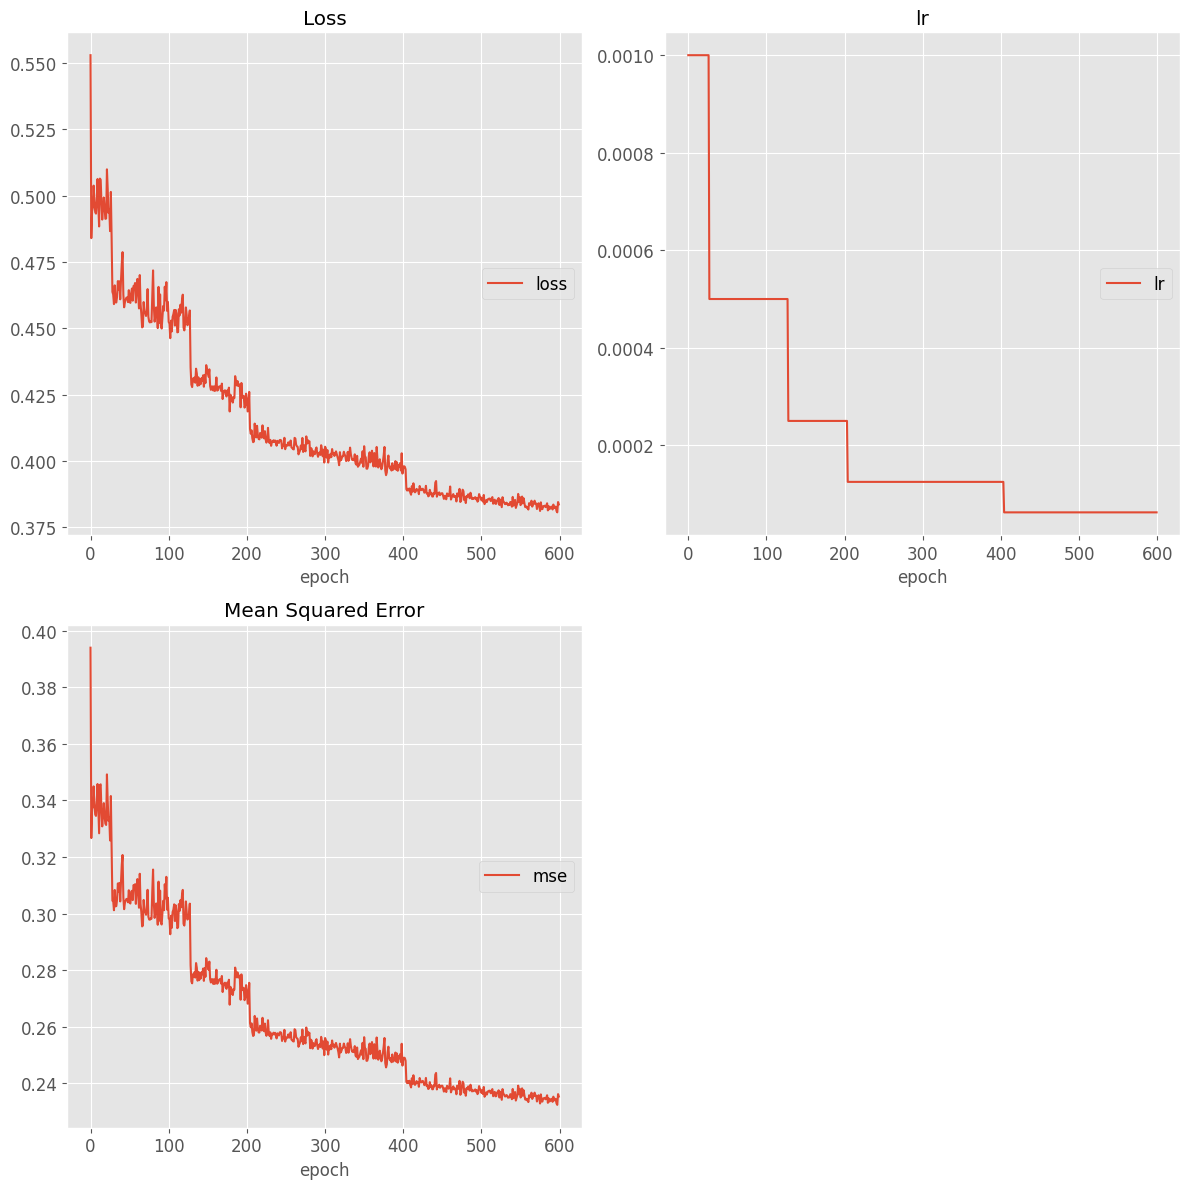

Loss
	loss             	 (min:    0.381, max:    0.553, cur:    0.384)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
Mean Squared Error
	mse              	 (min:    0.232, max:    0.394, cur:    0.235)
78/78 [==============================] - 1s 10ms/step - loss: 0.3836 - mse: 0.2353 - lr: 6.2500e-05


In [71]:
## First we need to starndardize the full train set like we did for the other subsets at the beging of the notebook
x_train_scaled_col = StandardScaler().fit_transform(x_train)

## Clear keras session, just in case some parameters are in memory
tf.keras.backend.clear_session()

########### INSTANTIATE THE MODEL WITH OPTMIZED HYPERPARAMENTER #####################
BATCH = 128
FILTER_SIZE = 45
L2_BETA = 0.015
LR=0.001 ## LR is now set to less than half of the LRmax that we used for the optimization to ensure stability of Adam

## initialize the model
model_cnn=create_model(FILTER_SIZE, L2_BETA)
  
    
########### COMPILE MODEL WITH ADAM OPTIMIZER #####################################

## Define the model name for saving purposes
MODEL_NAME = 'final_regression_model.h5'

## Load saved weights of the best model to improve convergence
model_cnn.load_weights("regression_models/pre-trained/study_trial=156.h5")

## Compile the model defining the optimizer, the loss function and the metrics to track during training
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mse', metrics=['mse'])  


########### DEFINE USEFUL CALLBACK FUNCTIONS #####################################

## Callbacks to use during training
early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-3, patience=50, mode='auto', restore_best_weights=True)  
rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='loss', verbose=1)
checkpointer = ModelCheckpoint(filepath=MODEL_NAME, monitor='loss', verbose=1, save_best_only=True)
plot_losses = PlotLossesKerasTF()

########### TRAIN THE MODEL #####################################################
## Train the model for an additional 300 epochs on the x_train data.
h2 = model_cnn.fit(x_train_scaled_col, y_train, batch_size=BATCH, epochs=600, 
      callbacks=[checkpointer, rdlr, early_stop, plot_losses],verbose=1)


Looking at the training history we can see that at the beginning of the train the model loss is more noisy. In these first epochs the model is still adjusting to the new data points. 
Now that our model is trained on all the training data, we can make a final prediction on our test set.

In [72]:
## Compute metrics for TRAIN and TEST sets
y_train_pred4 = model_cnn.predict(x_train_scaled_col)
y_test_pred4  = model_cnn.predict(x_test_scaled_col)

## Compute train error scores 
scoreR2_train = r2_score(y_train, y_train_pred4)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred4))

## Compute test error scores 
scoreR2_test = r2_score(y_test, y_test_pred4)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred4))
  
print('ERROR METRICS: \t TRAIN  \t\t TEST')
print('------------------------------------------------------')
print('R2: \t\t %5.3f  \t\t %5.3f'  % (scoreR2_train, scoreR2_test ))
print('RMSE: \t\t %5.3f \t\t\t %5.3f' % (rmse_train,rmse_test))

46/46 [==============================] - 0s 2ms/step
ERROR METRICS: 	 TRAIN  		 TEST
------------------------------------------------------
R2: 		 0.959  		 0.901
RMSE: 		 0.480 			 0.838


In this case, both R2 and RMSE improved when compared to the best model found during the optimization.

As it was mentioned earlier, training models on GPUs is faster but can induce some small uncertainty (different results) between different runs. As an alternative the user can choose to run the same model a few times (e.g. 10), average the final results and use that mean error to attest the final performance of the model.

The authors encourage the interested user to adapt this code to his/hers own problems and spectral analysis needs and explore the Optuna documentation to take full advantage of the tools it offers.